# Problema de Regressão

## Introdução

O problema tem como objetivo desenvolver um modelo de regressão multivariável que estimule o preço de um imóvel a partir de características do imóvel como por exemplo número de quartos, tipo de imóvel, presença de piscina, estacionamento, etc. Essa análise será realizada através dos dados coletados de 4683 imóveis, com os quais preveremos o preço de 2000 outros imóveis.

## Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Compreensão do dados

### Descrição dos Dados

- Id - identificação única do imóvel
- tipo - tipo de imóvel (apartamento, casa, loft ou quitinete)
- bairro - nome do bairro onde o imóvel se localiza
- tipo_vendedor - tipo de vendedor (imobiliária ou pessoa física)
- quartos - número de quartos
- suites - número de suítes
- vagas - número de vagas de garagem
- area_util - área útil, em metros quadrados
- area_extra - área extra, em metros quadrados
- diferenciais - descrição textual das duas principais características que diferenciam o imóvel
- churrasqueira - o anúncio menciona churrasqueira ( 1 = menciona ; 0 = não menciona )
- estacionamento - o anúncio menciona estacionamento para visitantes ( 1 = menciona ; 0 = não menciona )
- piscina - o anúncio menciona piscina ( 1 = menciona ; 0 = não menciona )
- playground - o anúncio menciona playground ( 1 = menciona ; 0 = não menciona )
- quadra - o anúncio menciona quadra esportiva ou campo de futebol ( 1 = menciona ; 0 = não menciona )
- s_festas - o anúncio menciona salão de festas ( 1 = menciona ; 0 = não menciona )
- s_jogos - o anúncio menciona salão de jogos ( 1 = menciona ; 0 = não menciona )
- s_ginastica - o anúncio menciona sala de ginástica ( 1 = menciona ; 0 = não menciona )
- sauna - o anúncio menciona sauna ( 1 = menciona ; 0 = não menciona )
- vista_mar - o anúncio menciona vista para o mar ( 1 = menciona ; 0 = não menciona )
- preco - preço de venda (valor a ser estimado, informado apenas no conjunto de treinamento

### Carregamento dos Dados

In [2]:
df_train = pd.read_csv(".\data\conjunto_de_treinamento.csv")

# Carregando conjunto de teste
df_test = pd.read_csv(".\data\conjunto_de_teste.csv")

#### Visuando cabeçalho do dataframe de treino

In [3]:
df_train.head()

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0


#### Descrição dos dados de treino

In [4]:
dict_type_features = {'Nome da Feature': df_train.columns, 'Tipo': df_train.dtypes.astype(str).tolist()}

info_colunas = pd.DataFrame(dict_type_features).reset_index(drop=True)
info_colunas

,Nome da Feature,Tipo
0,Id,int64
1,tipo,object
2,bairro,object
3,tipo_vendedor,object
4,quartos,int64
5,suites,int64
6,vagas,int64
7,area_util,int64
8,area_extra,int64
9,diferenciais,object


#### Listando variáveis categóricas

In [5]:
# Inicializar listas vazias para cada tipo diferente
tipos_diferentes = set(dict_type_features["Tipo"])
listas_por_tipo = {tipo: [] for tipo in tipos_diferentes}

# Organizar os dados nas listas apropriadas
for nome, tipo in zip(dict_type_features["Nome da Feature"], dict_type_features["Tipo"]):
    listas_por_tipo[tipo].append(nome)

listas_por_tipo['object']

['tipo', 'bairro', 'tipo_vendedor', 'diferenciais']

#### Descrevendo variáveis numéricas

In [6]:
df_train_features_numericals = df_train[listas_por_tipo['float64']] + df_train[listas_por_tipo['int64']]
df_train.describe()

,Id,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
count,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4.683000e+03
mean,4341.000000,3.043562,1.434337,1.708093,124.158018,13.293188,0.316891,0.030750,0.555627,0.157378,0.039078,0.138159,0.006833,0.013666,0.096306,0.027333,9.277053e+05
std,1352.009985,0.873590,1.102457,1.210975,107.365110,266.803756,0.465314,0.172657,0.496949,0.364195,0.193800,0.345104,0.082389,0.116114,0.295042,0.163069,1.050607e+07
min,2000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000e+02
25%,3170.500000,3.000000,1.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.550000e+05
50%,4341.000000,3.000000,1.000000,2.000000,96.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.150000e+05
75%,5511.500000,4.000000,2.000000,2.000000,149.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.300000e+05
max,6682.000000,9.000000,6.000000,30.000000,2045.000000,17450.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.300000e+08


### Tratamento de Dados Faltantes

- Verificando quantidade de dados faltantes

In [7]:
# Substitua todos os campos vazios por NaN
df_train.replace('', np.nan, inplace=True)
df_train.replace(' ', np.nan, inplace=True)
df_train

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,6678,Apartamento,Boa Viagem,Imobiliaria,4,4,3,170,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1200000.0
4679,6679,Apartamento,Setubal,Imobiliaria,2,0,1,82,0,churrasqueira,...,0,0,0,0,0,0,0,0,0,258000.0
4680,6680,Apartamento,Torre,Imobiliaria,3,1,1,75,0,nenhum,...,0,0,0,0,0,0,0,0,0,252000.0
4681,6681,Apartamento,Casa Amarela,Imobiliaria,3,2,3,136,0,piscina e copa,...,0,1,0,0,0,0,0,0,0,780000.0


In [8]:
tabela_dados_faltantes = df_train.isnull().sum().reset_index()
tabela_dados_faltantes.columns = ['Feature', 'Dados Faltantes']
tabela_dados_faltantes

,Feature,Dados Faltantes
0,Id,0
1,tipo,0
2,bairro,0
3,tipo_vendedor,0
4,quartos,0
5,suites,0
6,vagas,0
7,area_util,0
8,area_extra,0
9,diferenciais,0


##### Não há dados faltantes

### Análise Exploratória de Dados

#### Colunas do dataframe

In [9]:
df_train.columns

Index(['Id', 'tipo', 'bairro', 'tipo_vendedor', 'quartos', 'suites', 'vagas',
       'area_util', 'area_extra', 'diferenciais', 'churrasqueira',
       'estacionamento', 'piscina', 'playground', 'quadra', 's_festas',
       's_jogos', 's_ginastica', 'sauna', 'vista_mar', 'preco'],
      dtype='object')

#### Histograma

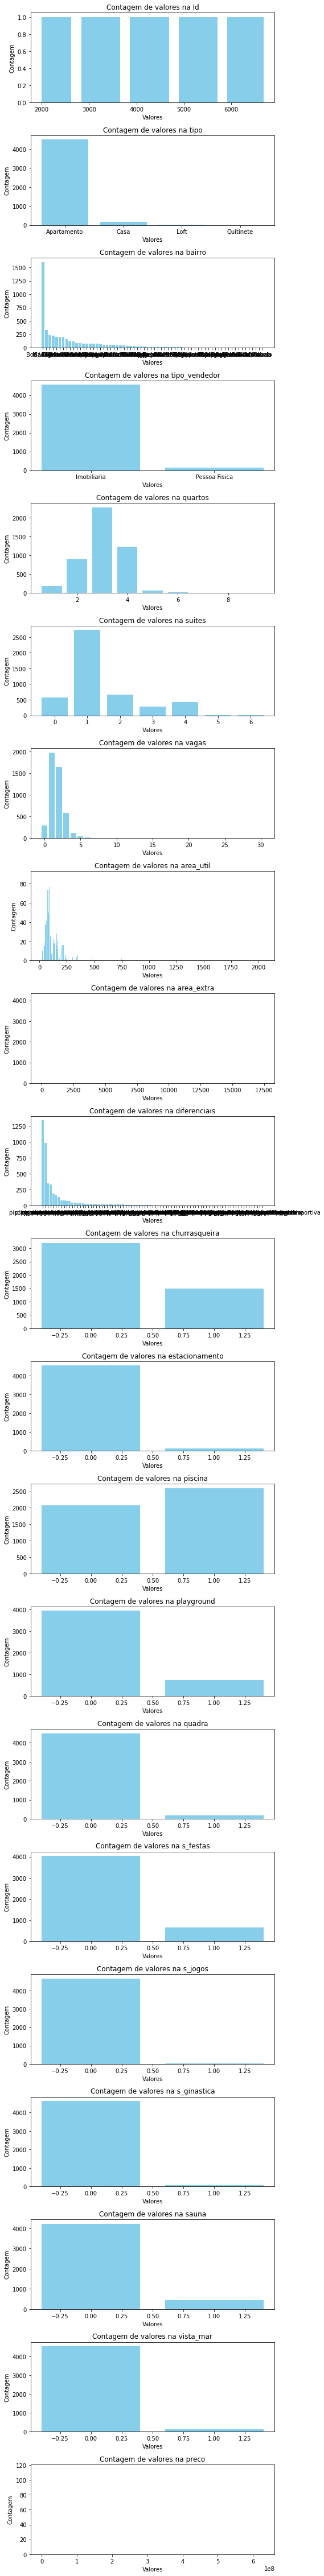

In [10]:
num_features = len(df_train.columns)
fig, axs = plt.subplots(num_features, 1, figsize=(8, 3 * num_features))

# Iterar sobre as colunas e criar gráficos de barras
for i, feature in enumerate(df_train.columns):
    contagem_valores = df_train[feature].value_counts()
    axs[i].bar(contagem_valores.index, contagem_valores.values, color='skyblue')
    axs[i].set_title(f'Contagem de valores na {feature}')
    axs[i].set_xlabel('Valores')
    axs[i].set_ylabel('Contagem')

plt.tight_layout()
plt.show()

#### Matriz de dispersão 

In [11]:
''' # Subconjunto do DataFrame contendo apenas as colunas mencionadas
selected_columns = ['Id', 'quartos', 'suites', 'vagas', 'area_util', 'area_extra', 'churrasqueira', 'estacionamento', 'piscina', 'playground', 'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna', 'vista_mar', 'preco']
df_subset = df_train[selected_columns]

sns.pairplot(df_subset)
plt.show() '''

" # Subconjunto do DataFrame contendo apenas as colunas mencionadas\nselected_columns = ['Id', 'quartos', 'suites', 'vagas', 'area_util', 'area_extra', 'churrasqueira', 'estacionamento', 'piscina', 'playground', 'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna', 'vista_mar', 'preco']\ndf_subset = df_train[selected_columns]\n\nsns.pairplot(df_subset)\nplt.show() "

## Pré-processamento de Dados

### Remoção dos Outliers


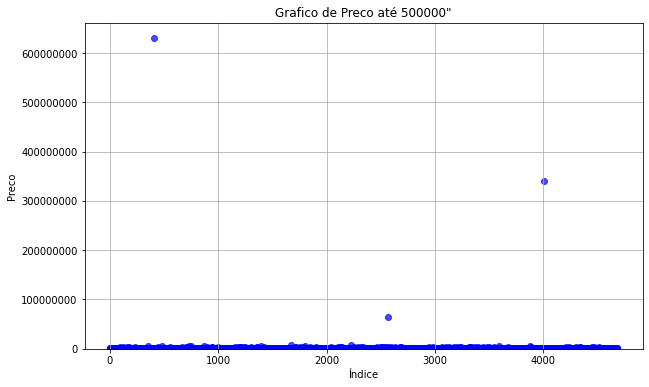

In [12]:
# Grafico do target
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df_train)), df_train['preco'], color='b', alpha=0.7)
plt.title('Grafico de Preco até 500000"')
plt.xlabel('Índice')
plt.ylabel('Preco')
plt.grid(True)

plt.ticklabel_format(axis='y', style='plain')
plt.ylim(bottom=0)

plt.show()

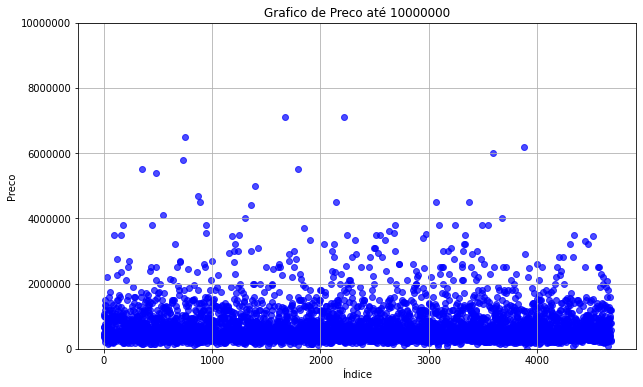

In [13]:
# Grafico do target
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df_train)), df_train['preco'], color='b', alpha=0.7)
plt.title('Grafico de Preco até 10000000')
plt.xlabel('Índice')
plt.ylabel('Preco')
plt.grid(True)

plt.ticklabel_format(axis='y', style='plain')

plt.ylim(top=10000000)
plt.ylim(bottom=0)

plt.show()

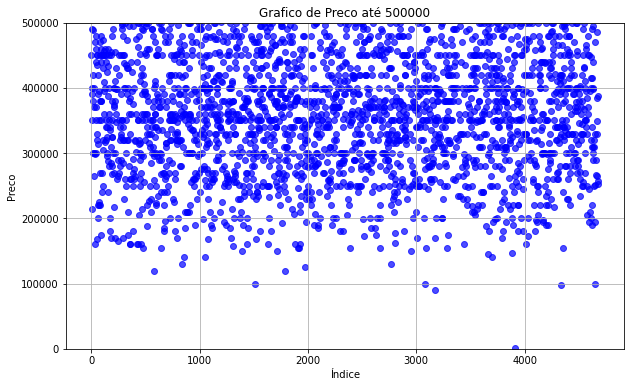

In [14]:
# Grafico do target
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df_train)), df_train['preco'], color='b', alpha=0.7)
plt.title('Grafico de Preco até 500000')
plt.xlabel('Índice')
plt.ylabel('Preco')
plt.grid(True)

plt.ticklabel_format(axis='y', style='plain')

plt.ylim(top=500000)
plt.ylim(bottom=0)

plt.show()

In [15]:
df_train = df_train[(df_train['preco']>= 50000) & (df_train['preco']<= 5000000)]


### Codificação de variáveis categóricas

- Features Categóricas


In [16]:

''' ['tipo', 'bairro', 'tipo_vendedor', 'diferenciais'] '''

" ['tipo', 'bairro', 'tipo_vendedor', 'diferenciais'] "

- Label Encoding: Estabelecendo ordem nominal

In [17]:
# Feature tipo

ordem_desejada = {'Quiitinet': 0, 'Loft': 1, 'Apartamento': 2, 'Casa': 3} #Ordem de valor estabelecido na maioria dos casos

df_train['tipo'] = df_train['tipo'].map(ordem_desejada)
label_encoder = LabelEncoder()
df_train['tipo'] = label_encoder.fit_transform(df_train['tipo'])

df_test['tipo'] = df_test['tipo'].map(ordem_desejada)
label_encoder = LabelEncoder()
df_test['tipo'] = label_encoder.fit_transform(df_test['tipo'])

C:\Users\amand\AppData\Local\Temp\ipykernel_28784\1553746050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tipo'] = df_train['tipo'].map(ordem_desejada)
C:\Users\amand\AppData\Local\Temp\ipykernel_28784\1553746050.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tipo'] = label_encoder.fit_transform(df_train['tipo'])


- Label Binarizer: Converte rótulos em inteiros, não tendo ordem nominal entre os valores da feature

In [18]:
def binarizador(colunas_a_binarizar, dataframe):
    binarizador = LabelBinarizer()
    for feature in colunas_a_binarizar:
        dataframe[feature] = binarizador.fit_transform(dataframe[feature])

    return dataframe

In [19]:
# tipo_vendedor -> #Imobiliário, Pessoa Física

colunas_a_binarizar = ['tipo_vendedor']

df_train = binarizador(colunas_a_binarizar, df_train)
df_test = binarizador(colunas_a_binarizar, df_test)

C:\Users\amand\AppData\Local\Temp\ipykernel_28784\2220310712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[feature] = binarizador.fit_transform(dataframe[feature])


- Codificando Diferenciais

In [20]:
# diferenciais

#separar itens da coluna feature
itens_separados = df_train['diferenciais'].str.split(' e |, ')
todos_itens = [item for sublist in itens_separados.dropna() for item in sublist]

# verificando frequencia de cada item
contagem_item = pd.Series(todos_itens).value_counts()

print(contagem_item)


#criando uma lista com cada diferencial que tenha
itens_unicos = list(set(todos_itens))


#removendo diferenciais com pouca frequencia
itens_unicos.remove('quadra de squash')
itens_unicos.remove("hidromassagem")
itens_unicos.remove("vestiario")
itens_unicos.remove("children care")
itens_unicos.remove("salao de jogos")
itens_unicos.remove("sala de ginastica")
itens_unicos.remove("quadra poliesportiva")
itens_unicos.remove("nenhum")


#removendo diferenciais citados em features especificas

itens_unicos.remove('churrasqueira')
itens_unicos.remove('frente para o mar')
itens_unicos.remove('sauna')
itens_unicos.remove('salao de festas')
itens_unicos.remove('piscina')

print(itens_unicos)

# codificando cada item

for item in itens_unicos:
    df_train['tem_'+item] = df_train['diferenciais'].str.contains(item, case=False, regex=False).map({True: 1, False: 0})

df_train = df_train.drop('diferenciais', axis=1)

for item in itens_unicos:
    df_test['tem_'+item] = df_test['diferenciais'].str.contains(item, case=False, regex=False).map({True: 1, False: 0})

df_test = df_test.drop('diferenciais', axis=1)


C:\Users\amand\AppData\Local\Temp\ipykernel_28784\144469197.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tem_'+item] = df_train['diferenciais'].str.contains(item, case=False, regex=False).map({True: 1, False: 0})
C:\Users\amand\AppData\Local\Temp\ipykernel_28784\144469197.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tem_'+item] = df_train['diferenciais'].str.contains(item, case=False, regex=False).map({True: 1, False: 0})
C:\Users\amand\AppData\Local\Temp\ipykernel_28784\

piscina                      2596
churrasqueira                1480
nenhum                        983
playground                    737
salao de festas               645
sauna                         450
copa                          320
estacionamento visitantes     144
frente para o mar             126
campo de futebol              108
esquina                       101
quadra poliesportiva           74
sala de ginastica              64
salao de jogos                 32
children care                   6
vestiario                       4
hidromassagem                   3
quadra de squash                1
dtype: int64
['playground', 'copa', 'campo de futebol', 'estacionamento visitantes', 'esquina']


C:\Users\amand\AppData\Local\Temp\ipykernel_28784\144469197.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tem_'+item] = df_train['diferenciais'].str.contains(item, case=False, regex=False).map({True: 1, False: 0})


### Dropando Features

In [21]:
df_train.columns

Index(['Id', 'tipo', 'bairro', 'tipo_vendedor', 'quartos', 'suites', 'vagas',
       'area_util', 'area_extra', 'churrasqueira', 'estacionamento', 'piscina',
       'playground', 'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna',
       'vista_mar', 'preco', 'tem_playground', 'tem_copa',
       'tem_campo de futebol', 'tem_estacionamento visitantes', 'tem_esquina'],
      dtype='object')

In [22]:
df_train['tipo']

0       2
1       1
2       1
3       1
4       1
       ..
4678    1
4679    1
4680    1
4681    1
4682    1
Name: tipo, Length: 4670, dtype: int64

- bairro será removido por ser uma feature categorica não codificada

In [23]:
df_train = df_train.drop('bairro', axis=1)

df_test = df_test.drop('bairro', axis=1)

## Modelagem

### Seleção de Features

#### Removemos as features que não são de interesse ou não parecem ter muita correlação pelas análises

In [24]:
df_train.columns

Index(['Id', 'tipo', 'tipo_vendedor', 'quartos', 'suites', 'vagas',
       'area_util', 'area_extra', 'churrasqueira', 'estacionamento', 'piscina',
       'playground', 'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna',
       'vista_mar', 'preco', 'tem_playground', 'tem_copa',
       'tem_campo de futebol', 'tem_estacionamento visitantes', 'tem_esquina'],
      dtype='object')

In [25]:
#colunas selecionas

colunas_selecionadas = df_train.columns.tolist()
colunas_selecionadas.remove('Id')  #removida pois é o id
colunas_selecionadas.remove('preco') # removida pois é o target


colunas_selecionadas

['tipo',
 'tipo_vendedor',
 'quartos',
 'suites',
 'vagas',
 'area_util',
 'area_extra',
 'churrasqueira',
 'estacionamento',
 'piscina',
 'playground',
 'quadra',
 's_festas',
 's_jogos',
 's_ginastica',
 'sauna',
 'vista_mar',
 'tem_playground',
 'tem_copa',
 'tem_campo de futebol',
 'tem_estacionamento visitantes',
 'tem_esquina']

### Escolha do Modelo

#### Definindo conjuntos de teste e treino

In [26]:
# selecionando colunas

X_train = df_train[colunas_selecionadas].iloc[:,:].values #pega todas as colunas selecionadas
y_train = df_train["preco"].iloc[:,].values #pega somente a coluna preco

# conjunto de teste (5000) sem target

X_test_output = df_test[colunas_selecionadas].iloc[:,:].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, 
    y_train.ravel(),
    train_size=0.8,
    shuffle=True,
    random_state=777
    )

- Escrevendo dados padronizados

In [28]:
''' scaler = StandardScaler()

df_train_standard = pd.DataFrame(scaler.fit_transform(df_train[colunas_selecionadas+["preco"]]), columns=colunas_selecionadas+["preco"])

X_train_standard = df_train_standard.iloc[:,df_train_standard.columns!='preco'].values #pega todas as colunas selecionadas
y_train_standard = df_train_standard["preco"].iloc[:,].values #pega somente a coluna preco

# conjunto de teste (5000) sem target

df_test_standard = pd.DataFrame(scaler.fit_transform(df_test[colunas_selecionadas]), columns=colunas_selecionadas)

X_test_output_standard = df_test_standard[colunas_selecionadas].iloc[:,:].values '''


scaler = StandardScaler()
scaler.fit(X_train)

X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

In [29]:
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(
    X_train_standard, 
    y_train_standard.ravel(),
    train_size=0.8,
    shuffle=True,
    random_state=777
    )

NameError: name 'y_train_standard' is not defined

In [ ]:
# Função para submeter para o Kaggle

def submissao_kaggle(df_test, y_predict_output, nome_file):
    
    id_solicitante = df_test.loc[:,df_test.columns=='Id'].values

    id_solicitante = id_solicitante.ravel()
    y_predict_output =  y_predict_output.ravel()

    dict_input = {'Id': id_solicitante, 'preco': y_predict_output}
    input_classificador = pd.DataFrame(data = dict_input)

    input_classificador.to_csv(nome_file, index = False)

#### RMSPE

In [ ]:
def rmspe(y_true, y_predict):

    assert len(y_true) == len(y_predict), "Os arrays devem ter o mesmo comprimento."
    
    errors = (y_true - y_predict) / y_true
    squared_errors = np.square(errors)
    mean_squared_errors = np.mean(squared_errors)
    rmspe = np.sqrt(mean_squared_errors)
    
    return rmspe

#### Linear Regression

In [ ]:
def regressorLinear(X_train, y_train, X_test, y_test):

    model = LinearRegression()
    model.fit(X_train,y_train)
    y_predict  = model.predict(X_test)

    rmspe_score = rmspe(y_test, y_predict)

    return [y_predict, rmspe_score ]

- Treinar o modelo Regressor Linear com o conjunto de treino sem utilizar medidas padronizadas


In [ ]:
result = regressorLinear(X_train, y_train, X_test, y_test)

print("RMSPE: ", result[1])

- Predição para os dados de teste

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
y_predict_output  = model.predict(X_test_output)
submissao_kaggle(df_test, y_predict_output, "input_regressor_linear_sem_padronizacao.csv")

- Treinar o modelo de Regressão Linear com o conjunto de treino utilizando medidas padronizadas

In [ ]:
result = regressorLinear(X_train_standard, y_train_standard, X_test_standard, y_test_standard)

print("RMSPE: ", result[1])

- Predição para os dados de teste

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
y_predict_output  = model.predict(X_test_output)
submissao_kaggle(df_test, y_predict_output, "input_regressor_linear_com_padronizacao.csv")

#### Polinomial Regression



##### Treinando modelo

In [ ]:
def regressorPolinomial(X_train, y_train, X_test, y_test):
    results = []
    for g in range(1, 4):

        model = PolynomialFeatures(degree=g)

        model = model.fit(X_train)
        X_train_poly = model.transform(X_train)
        X_test_poly = model.transform(X_test)

        regressor_linear = LinearRegression()

        regressor_linear = regressor_linear.fit(X_train_poly,y_train)

        y_predict_train = regressor_linear.predict(X_train_poly)
        y_predict_test  = regressor_linear.predict(X_test_poly)


        rmspe_score = rmspe(y_test, y_predict_test)

        result = [g, rmspe_score]

        results.append(result)

    return pd.DataFrame(results, columns=["degree", "rmspe_score"])
        
        

- Treinar o modelo de regressão com o conjunto de treino sem utilizar medidas padronizadas


In [ ]:
result = regressorPolinomial(X_train, y_train, X_test, y_test)

- Decidindo melhor degree

In [ ]:
result_sort = result[0].sort_values(by='rmspe_score', ascending=True)
result_sort

- Predição para os dados de teste

In [ ]:
model = PolynomialFeatures(degree=g)

model = model.fit(X_train)
X_train_poly = model.transform(X_train)
X_test_poly = model.transform(X_test)

regressor_linear = LinearRegression()

regressor_linear = regressor_linear.fit(X_train_poly,y_train)


X_test_output_poly = model.transform(X_test_output)
y_predict_output  = model.predict(X_test_output_poly)
submissao_kaggle(df_test, y_predict_output, "input_regressor_polinomial_sem_padronizacao.csv")

#### KNN

##### Treinando modelo

- Parâmetros considerados
    - n_neighbors:
        - O número de vizinhos.
    - weights (Função peso usada na predição): 
        - Se “uniform”, então os pesos são uniformes.
        - Se “distance”, então os pesos são inversosa sua distância. 

In [ ]:
def regressorKNN(X_train, y_train, X_test, y_test):
    results = []
    for k in range(1, 50):

        model = KNeighborsRegressor(n_neighbors=k,weights='uniform')
        model.fit(X_train,y_train)
        y_predict  = model.predict(X_test)

        rmspe_score = rmspe(y_test, y_predict)

        result_uniform = [k, "uniform", rmspe_score]

        results.append(result_uniform)

        model = KNeighborsRegressor(n_neighbors=k,weights='distance')
        model.fit(X_train,y_train)
        y_predict  = model.predict(X_test)

        rmspe_score = rmspe(y_test, y_predict)

        result_distance = [k, "distance", rmspe_score]

        results.append(result_distance)

    return pd.DataFrame(results, columns=["n_neighbors", "weights", "rmspe_score"])
        
        

- Treinar o modelo KNN com o conjunto de treino sem utilizar medidas padronizadas


In [ ]:
result = regressorKNN(X_train, y_train, X_test, y_test)

- Decidindo melhor n_neighbors e melhor weights

In [ ]:
result_sort = result[0].sort_values(by='rmspe_score', ascending=True)
result_sort

- Predição para os dados de teste

In [ ]:
model = KNeighborsRegressor(n_neighbors=11,weights='distance')
model.fit(X_train,y_train)
y_predict_output  = model.predict(X_test_output)
submissao_kaggle(df_test, y_predict_output, "input_regressor_knn_sem_padronizacao.csv")

- Treinar o modelo KNN com o conjunto de treino utilizando medidas padronizadas

In [ ]:
result = regressorKNN(X_train_standard, y_train_standard, X_test_standard, y_test_standard)

- Decidindo melhor n_neighbors e melhor weights

In [ ]:
result_sort = result[0].sort_values(by="rmspe_score", ascending=True)
result_sort

- Predição para os dados de teste

In [ ]:
model = KNeighborsRegressor(n_neighbors=13,weights='distance')
model.fit(X_train_standard,y_train_standard)
y_predict_output  = model.predict(X_test_output)
submissao_kaggle(df_test, y_predict_output, "input_regressor_knn_com_padronizacao.csv")

##### Random Forest

##### Treinando modelo

- Parâmetros considerados
    - n_estimators:
        - O número de árvores na floresta.
    - max_features: 
        - Se “sqrt”, então max_features=sqrt(n_features).
        - Se “log2”, então max_features=log2(n_features)

In [ ]:
def regressorRandomForest(X_train, y_train, X_test, y_test):
    results = []
    for k in range(1, 50):

        model = RandomForestRegressor(n_estimators=k,        max_features='sqrt',
        oob_score=True,
        max_depth=None,
        random_state=123
        )
        model.fit(X_train,y_train)
        y_predict  = model.predict(X_test)

        rmspe_score = rmspe(y_test, y_predict)

        result_sqrt = [k, "sqrt", rmspe_score]

        results.append(result_sqrt)

        model = RandomForestRegressor(n_estimators=k,        
        max_features='log2',
        oob_score=True,
        max_depth=None,
        random_state=123
        )
        model.fit(X_train,y_train)
        y_predict  = model.predict(X_test)

        rmspe_score = rmspe(y_test, y_predict)

        result_log2 = [k, "log2", rmspe_score]

        results.append(result_log2)

    return [pd.DataFrame(results, columns=["n_estimators", "max_features", "rmspe_score"]), y_predict]

- Treinar o modelo Random Forest com o conjunto de treino sem utilizar medidas padronizadas

In [ ]:
result = regressorRandomForest(X_train, y_train, X_test, y_test)

- Decidindo melhor n_neighbors e melhor weights

In [ ]:
result_sort = result[0].sort_values(by="rmspe_score", ascending=True)
result_sort

- Predição para os dados de teste

In [ ]:
model = RandomForestRegressor(n_estimators=27,        
max_features='log2',
oob_score=True,
max_depth=None,
random_state=123
)
model.fit(X_train,y_train)
y_predict_output  = model.predict(X_test_output)

submissao_kaggle(df_test, y_predict_output, "input_regressor_randomforest_sem_padronizacao.csv")

- Treinar o modelo Random Forest com o conjunto de treino utilizando medidadas padronizadas

In [ ]:
result = regressorRandomForest(X_train_standard, y_train_standard, X_test_standard, y_test_standard)

- Decidindo melhor n_neighbors e melhor weights

In [ ]:
result_sort = result[0].sort_values(by="rmspe_score", ascending=True)
result_sort

- Predição para os dados de teste

In [ ]:
model = RandomForestRegressor(n_estimators=36,        
max_features='sqrt',
oob_score=True,
max_depth=None,
random_state=123
)
model.fit(X_train_standard,y_train_standard)
y_predict_output  = model.predict(X_test_output_standard)
submissao_kaggle(df_test, y_predict_output, "input_regressor_randomforest_com_padronizacao.csv")

## Conclusão

- A partir dos dados de acurácia temos que o melhor modelo foi Random Forest, sendo este utilizado para dados não padronizados.